In [12]:
import json
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from bilby.core.result import read_in_result
from cycler import cycler
from tqdm.auto import trange

%matplotlib inline

In [13]:
def set_mpl():
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Computer Modern Roman"
    mpl.rcParams["font.size"] = 20
    mpl.rcParams["text.usetex"] = True
    mpl.rcParams["grid.alpha"] = 0

    colorblind=["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC", "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"]
    mpl.rcParams["axes.prop_cycle"] = cycler(color=colorblind)

set_mpl()

In [14]:
result = read_in_result("/home/colm.talbot/O3/population/O3b/no_limits/n_events_scaling/10/result/69_mass_c_iid_spin_magnitude_mag_iid_spin_orientation_tilt_powerlaw_redshift_result.json")
events = result.meta_data["event_ids"]
idxs = np.argsort(events)

dates = np.array([int(re.findall("[0-9]{6}", event)[0]) for event in events])[idxs]

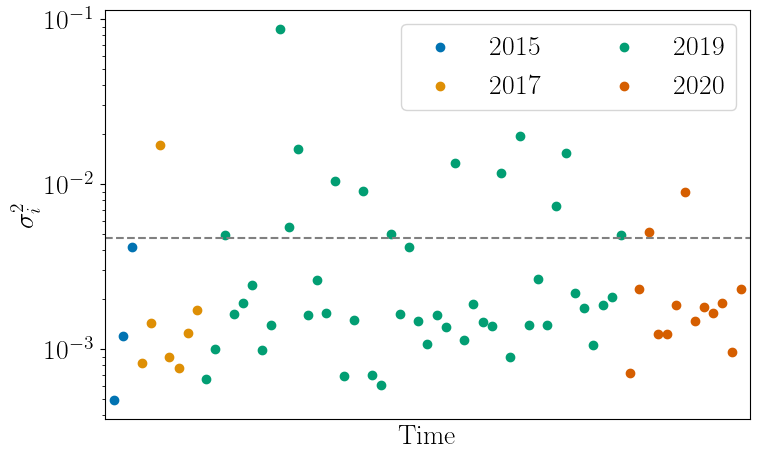

In [15]:
plt.figure(figsize=(8, 5))
values = np.genfromtxt("/home/colm.talbot/O3/population/O3b/uncertainty/per_event/1_1")[1][idxs]
plt.axhline(np.mean(values), linestyle="--", color="gray")
for ii, (value, date) in enumerate(zip(values, dates)):
    plt.scatter(ii, value, color=f"C{(date // 10000 - 14) // 2}")
for ii, year in enumerate([15, 17, 19, 20]):
    plt.scatter(-5, 0.01, color=f"C{ii}", label=f"20{year}")
plt.legend(loc="upper right", ncol=2)
plt.xticks([], [])
plt.xlabel("Time")
plt.ylabel("$\sigma^{2}_{i}$")
plt.yscale("log")
plt.xlim(-1, 69)
plt.tight_layout()
plt.savefig("figure-2.pdf")
plt.show()
plt.close()

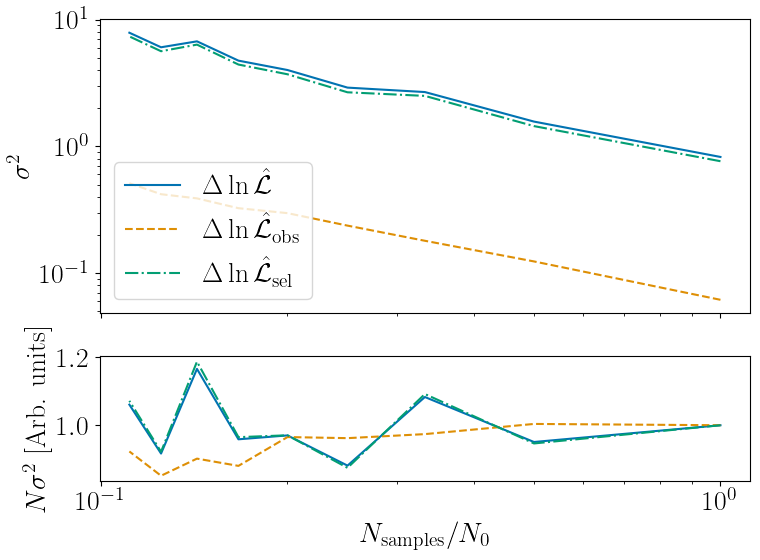

In [17]:
with open(f"/home/colm.talbot/O3/population/O3b/uncertainty/LVK/fits.json", "r") as ff:
    fits = json.load(ff)

jmax = len([key for key in fits if "_69" in key])

fig, axes = plt.subplot_mosaic([["sigma"], ["sigma"], ["fraction"]], sharex=True, figsize=(8, 6))
axes["sigma"].set_xscale("log")
axes["sigma"].set_yscale("log")
axes["fraction"].set_xlabel("$N_{\\rm samples} / N_{0}$")
axes["sigma"].set_ylabel("$\\sigma^2$")
axes["fraction"].set_ylabel("$N \\sigma^2$ [Arb. units]")

for idx, (kind, label) in enumerate(zip(["raw", "cov"][1:], ["$\\ln \\hat{\\cal L}", "$\\Delta \\ln \\hat{\\cal L}"][1:])):
    yvals = np.array([fits[f"{jj}_{jj}_{69}"][kind] for jj in range(1, jmax)])
    axes["fraction"].plot(1 / np.arange(1, jmax), yvals / yvals[0] / np.arange(1, jmax), color=f"C{idx}")
    axes["sigma"].plot(1 / np.arange(1, jmax), yvals, label=label + "$", color=f"C{idx}")

    yvals = np.array([fits[f"{jj}_{jj}_69"][f"{kind}_pop"] for jj in range(1, jmax)])
    axes["fraction"].plot(1 / np.arange(1, jmax), yvals / yvals[0] / np.arange(1, jmax), linestyle="--", color=f"C1")
    axes["sigma"].plot(1 / np.arange(1, jmax), yvals, label=label + "_{\\rm obs}$", linestyle="--", color=f"C1")

    yvals = np.array([fits[f"{jj}_{jj}_69"][f"{kind}_sel"] for jj in range(1, jmax)])
    axes["fraction"].plot(1 / np.arange(1, jmax), yvals / yvals[0] / np.arange(1, jmax), linestyle="-.", color=f"C2")
    axes["sigma"].plot(1 / np.arange(1, jmax), yvals, label=label + "_{\\rm sel}$", linestyle="-.", color=f"C2")
axes["sigma"].legend(loc="lower left")
plt.tight_layout()
plt.savefig("figure-3.pdf")
plt.show()
plt.close()

1.2773982641416664 0.0898707928526569
0.7178357402973914 0.10995552223852154
1.5240662252774637 0.050756729272725426


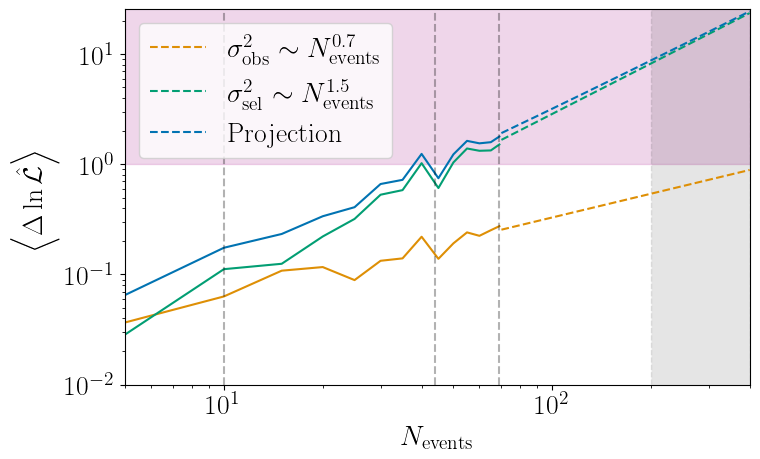

In [20]:
xvals = np.arange(70, 400)
prediction = xvals * 0.0
total = np.zeros(14)

plt.figure(figsize=(8, 5))
for jj, target in enumerate(["cov", "cov_pop", "cov_sel"]):
    yvals = list()
    _vals = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 69][:]
    vals = list()
    for ii, path in enumerate(_vals):
        try:
            with open(f"/home/colm.talbot/O3/population/O3b/uncertainty/n_events/{path}/fits.json", "r") as ff:
                fits = json.load(ff)
            vals.append(path)
        except IOError:
            continue
        yvals.append(fits[f"1_1_{path}"][target])
    yvals = np.array(yvals)
    if "sel" in target or "pop" in target:
        total[:len(yvals)] += yvals

    if jj > 0:
        plt.plot(
            xvals,
            np.exp(np.polyval(np.polyfit(np.log(vals), np.log(yvals), 1), np.log(xvals))),
            color=f"C{jj}",
            linestyle="--",
            label=f"$\\sigma^{{2}}_{{\\{['rm obs', 'rm sel'][jj - 1]}}} \\sim N_{{\\rm events}}^{{{np.polyfit(np.log(vals), np.log(yvals), 1)[0]:.1f}}}$"
        )
        prediction += np.exp(np.polyval(np.polyfit(np.log(vals), np.log(yvals), 1), np.log(xvals)))
        plt.plot(vals, yvals, color=f"C{jj}", linestyle="-")

plt.plot(vals, total[:len(vals)], color="C0")
plt.plot(xvals, prediction, color="C0", linestyle="--", label="Projection")

plt.xlim(5, 400)
plt.ylim(1e-2)
plt.xlabel("$N_{\\rm events}$")
plt.ylabel("$\\left\\langle \\Delta \\ln \\hat{\\cal L} \\right\\rangle$")
plt.axvline(10, color="k", linestyle="--", alpha=0.3)
plt.axvline(44, color="k", linestyle="--", alpha=0.3)
plt.axvline(69, color="k", linestyle="--", alpha=0.3)
xvals = np.arange(5, 400)
plt.fill_between(xvals, xvals**0, xvals**0 * 60, alpha=0.3, color="C4")
plt.fill_betweenx([0, 60], [200, 200], [max(xvals), max(xvals)], alpha=0.1, color="k", linestyle="--")
plt.legend(loc="upper left")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figure-3.pdf")
plt.show()
plt.close()

In [23]:
mapping = dict(
    LVK="LVK",
    production="No Convergence",
    tuned="Tailored",
    more_injections="More Injections",
    no_injections="No Injections",
)

for directory, label in mapping.items():
    filename = f"/home/colm.talbot/O3/population/O3b/uncertainty/{directory}/covariance.npz"
    data = np.load(filename)
    if "no_injections" in filename:
        _vars = data["pop"][:]
    elif "tuned" in filename:
        # correct for the fact that the tailored injection set has 11.29 times as many
        # found injections as the LVK data set
        _vars = data["sel"][:] * 11.29 + data["pop"][:]
    else:
        _vars = data["sel"][:] + data["pop"][:]
    mean_covariance = np.nanmean(
        np.add.outer(_vars.diagonal(), _vars.diagonal()) - 2 * _vars
    )
    print(f"{mapping[directory]}: {mean_covariance:.2f}")

LVK: 0.63
No Convergence: 5.06
Tailored: 1.24
More Injections: 0.50
No Injections: 0.42
